In [129]:
!git clone https://github.com/venkyyuvy/image_classifier.git

Cloning into 'image_classifier'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 26 (delta 10), reused 25 (delta 9), pack-reused 0
Unpacking objects: 100% (26/26), 240.83 KiB | 1.96 MiB/s, done.


In [130]:
cd image_classifier/S6

/content/image_classifier/S6/image_classifier/S6


In [131]:
import torch
from torch import optim, nn

from model import Net, model_train, model_test,\
     summary_printer, plot_loss_n_acc
from utils import prepare_mnist_data,\
     plot_img_batch

from torchvision import transforms
from torch.nn import functional as F

In [132]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Data preparation

In [133]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

In [134]:
train_loader, test_loader = prepare_mnist_data(
    train_transforms, test_transforms, batch_size=16)

100%|██████████| 9912422/9912422 [00:00<00:00, 47676380.95it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 42668437.42it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 12090254.22it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7164546.36it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



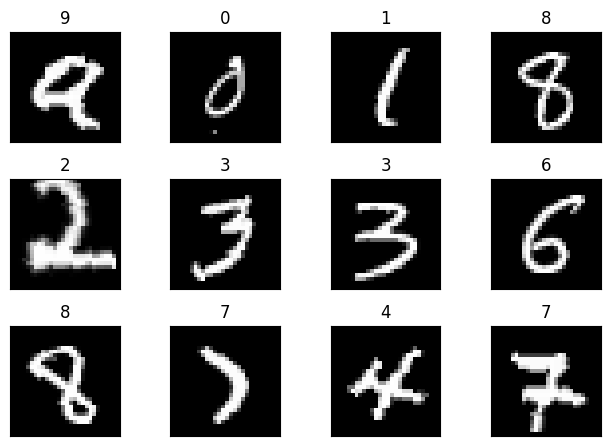

In [135]:
_ = plot_img_batch(train_loader)

## Modelling

In [170]:

class Net(nn.Module):
    def __init__(self, drop_p=0.15):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            nn.Dropout(drop_p)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 16, 1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            nn.Dropout(drop_p)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 128, 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(drop_p)
        )
        self.avg = nn.AvgPool2d(2)
        self.fc = nn.Sequential(
            nn.Linear(128, 10)
        )
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        return x

In [171]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary_printer(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
       BatchNorm2d-3           [-1, 32, 28, 28]              64
            Conv2d-4           [-1, 16, 28, 28]           4,624
              ReLU-5           [-1, 16, 28, 28]               0
       BatchNorm2d-6           [-1, 16, 28, 28]              32
         MaxPool2d-7           [-1, 16, 14, 14]               0
           Dropout-8           [-1, 16, 14, 14]               0
            Conv2d-9           [-1, 16, 16, 16]             272
             ReLU-10           [-1, 16, 16, 16]               0
      BatchNorm2d-11           [-1, 16, 16, 16]              32
           Conv2d-12           [-1, 32, 16, 16]           4,640
             ReLU-13           [-1, 32, 16, 16]               0
      BatchNorm2d-14           [-1, 32,

In [166]:


optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
num_epochs = 20


for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    model_train(model, device, train_loader, optimizer)
    model_test(model, device, test_loader)
    scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 1


Train: Loss=0.0870             Batch_id=3749 Accuracy=87.11: 100%|██████████| 3750/3750 [00:55<00:00, 67.68it/s]


Test set: Average loss: 0.0775,        Accuracy: 58602/60000 (97.67%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 2


Train: Loss=0.4040             Batch_id=3749 Accuracy=94.74: 100%|██████████| 3750/3750 [00:55<00:00, 67.94it/s]


Test set: Average loss: 0.0546,        Accuracy: 59013/60000 (98.36%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 3


Train: Loss=0.0301             Batch_id=3749 Accuracy=95.57: 100%|██████████| 3750/3750 [00:55<00:00, 67.36it/s]


Test set: Average loss: 0.0427,        Accuracy: 59218/60000 (98.70%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 4


Train: Loss=0.0018             Batch_id=3749 Accuracy=96.33: 100%|██████████| 3750/3750 [00:56<00:00, 65.89it/s]


Test set: Average loss: 0.0478,        Accuracy: 59092/60000 (98.49%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 5


Train: Loss=0.0559             Batch_id=3749 Accuracy=96.49: 100%|██████████| 3750/3750 [00:54<00:00, 68.25it/s]


Test set: Average loss: 0.0451,        Accuracy: 59146/60000 (98.58%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 6


Train: Loss=0.0394             Batch_id=3749 Accuracy=96.69: 100%|██████████| 3750/3750 [00:56<00:00, 66.29it/s]


Test set: Average loss: 0.0384,        Accuracy: 59256/60000 (98.76%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 7


Train: Loss=0.0031             Batch_id=3749 Accuracy=96.86: 100%|██████████| 3750/3750 [00:54<00:00, 68.18it/s]


Test set: Average loss: 0.0333,        Accuracy: 59374/60000 (98.96%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 8


Train: Loss=0.1048             Batch_id=3749 Accuracy=97.05: 100%|██████████| 3750/3750 [00:57<00:00, 65.02it/s]


Test set: Average loss: 0.0288,        Accuracy: 59420/60000 (99.03%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 9


Train: Loss=0.1879             Batch_id=3749 Accuracy=97.12: 100%|██████████| 3750/3750 [00:55<00:00, 66.97it/s]


Test set: Average loss: 0.0279,        Accuracy: 59460/60000 (99.10%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 10


Train: Loss=0.0085             Batch_id=3749 Accuracy=97.34: 100%|██████████| 3750/3750 [00:54<00:00, 68.36it/s]


Test set: Average loss: 0.0311,        Accuracy: 59411/60000 (99.02%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 11


Train: Loss=0.0077             Batch_id=3749 Accuracy=97.34: 100%|██████████| 3750/3750 [00:54<00:00, 69.39it/s]


Test set: Average loss: 0.0284,        Accuracy: 59434/60000 (99.06%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 12


Train: Loss=0.0697             Batch_id=3749 Accuracy=97.51: 100%|██████████| 3750/3750 [00:51<00:00, 72.50it/s]


Test set: Average loss: 0.0254,        Accuracy: 59529/60000 (99.22%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 13


Train: Loss=0.1505             Batch_id=3749 Accuracy=97.53: 100%|██████████| 3750/3750 [00:57<00:00, 65.59it/s]


Test set: Average loss: 0.0249,        Accuracy: 59516/60000 (99.19%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 14


Train: Loss=0.0023             Batch_id=3749 Accuracy=97.70: 100%|██████████| 3750/3750 [00:57<00:00, 65.58it/s]


Test set: Average loss: 0.0240,        Accuracy: 59528/60000 (99.21%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 15


Train: Loss=0.0113             Batch_id=3749 Accuracy=97.61: 100%|██████████| 3750/3750 [00:57<00:00, 65.78it/s]


Test set: Average loss: 0.0234,        Accuracy: 59534/60000 (99.22%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 16


Train: Loss=0.2148             Batch_id=3749 Accuracy=98.09: 100%|██████████| 3750/3750 [00:58<00:00, 64.11it/s]


Test set: Average loss: 0.0190,        Accuracy: 59633/60000 (99.39%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 17


Train: Loss=0.0069             Batch_id=3749 Accuracy=98.20: 100%|██████████| 3750/3750 [00:57<00:00, 65.15it/s]


Test set: Average loss: 0.0191,        Accuracy: 59633/60000 (99.39%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 18


Train: Loss=0.0011             Batch_id=3749 Accuracy=98.23: 100%|██████████| 3750/3750 [00:57<00:00, 65.34it/s]


Test set: Average loss: 0.0175,        Accuracy: 59665/60000 (99.44%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 19


Train: Loss=0.0179             Batch_id=3749 Accuracy=98.21: 100%|██████████| 3750/3750 [00:58<00:00, 64.31it/s]


Test set: Average loss: 0.0173,        Accuracy: 59674/60000 (99.46%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 20


Train: Loss=0.0454             Batch_id=3749 Accuracy=98.30: 100%|██████████| 3750/3750 [00:57<00:00, 65.63it/s]


Test set: Average loss: 0.0167,        Accuracy: 59676/60000 (99.46%)

Adjusting learning rate of group 0 to 1.0000e-04.


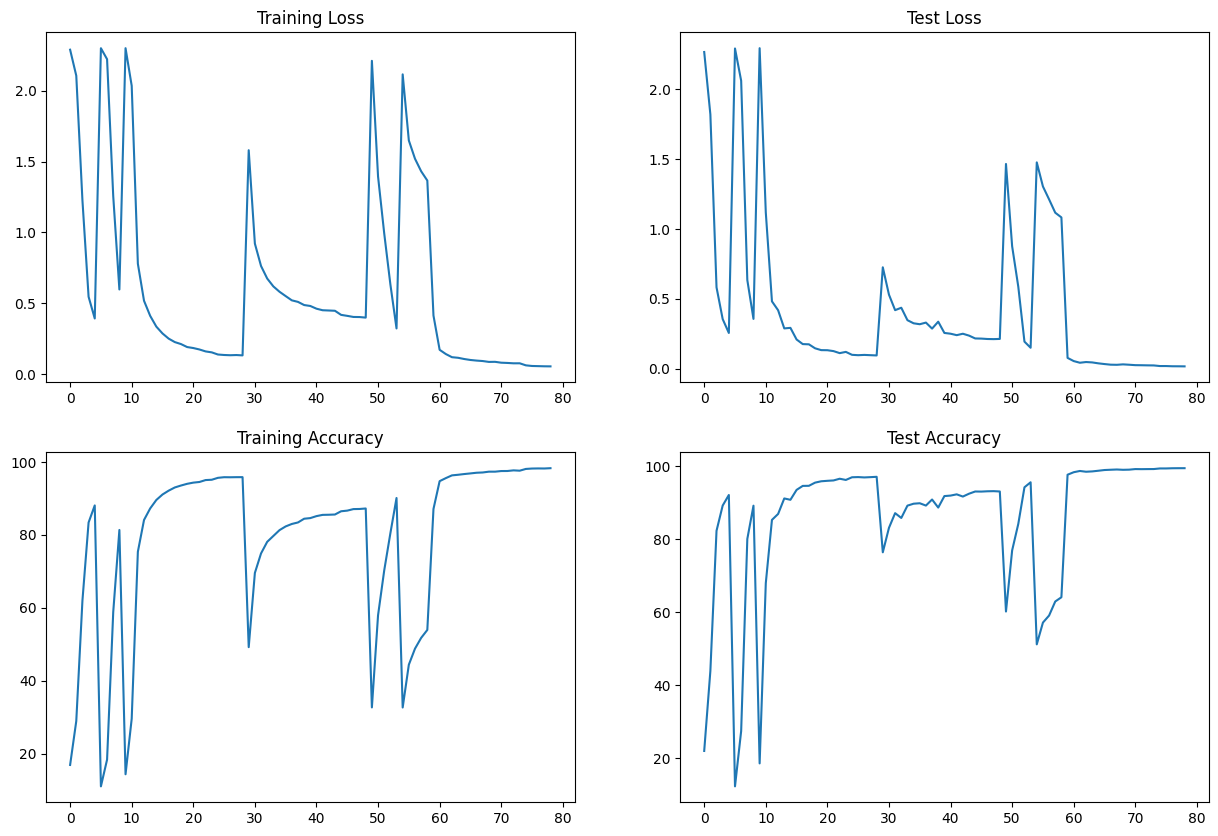

In [167]:
plot_loss_n_acc()